In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
sample_image = mnist.train.next_batch(1)
print(sample_image[1])

[2]


In [6]:
sample_image = sample_image[0].reshape([28,28])

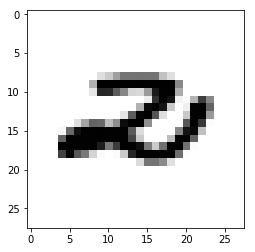

In [7]:
plt.imshow(sample_image, cmap='Greys')

In [43]:
def discriminator(images, reuse=False):
    if(reuse):
        tf.get_variable_scope().reuse_variables()
    
    with tf.variable_scope('D_conv1'):
        d_w1 = tf.get_variable('d_w1', [5,5,1,32], 
                               initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1,1,1,1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    
    with tf.variable_scope('D_conv2'):
        d_w2 = tf.get_variable('d_w2', [5,5,32,64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1,1,1,1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1,2,2,1],strides=[1,2,2,1], padding='SAME')
    
    with tf.variable_scope('D_fc3'):
        d_w3 = tf.get_variable('d_w3', [7*7*64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7*7*64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)
    
    with tf.variable_scope('D_fc4'):
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4
    
    return d4

In [44]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56,56,1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    g_w2 = tf.get_variable('g_w2', [3,3,1,z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1,2,2,1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56,56])
    
    g_w3 = tf.get_variable('g_w3', [3,3,z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1,2,2,1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56,56])
    
    g_w4 = tf.get_variable('g_w4', [1,1,z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1,2,2,1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    return g4

In [75]:
z_dimensions = 100

In [11]:
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [12]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)

In [13]:
z_batch = np.random.normal(0,1,[1,z_dimensions])

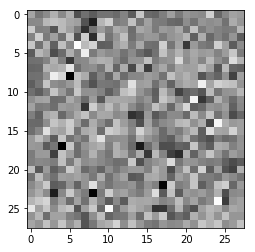

In [14]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28,28])
    plt.imshow(generated_image, cmap='Greys')

In [59]:
tf.reset_default_graph()

In [77]:
batch_size = 50
z_dimension = 100

In [61]:
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')

In [62]:
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x_placeholder')

In [63]:
with tf.variable_scope(tf.get_variable_scope()):
    Gz = generator(z_placeholder, batch_size, z_dimensions)
    Dx = discriminator(x_placeholder)
    Dg = discriminator(Gz, reuse=True)

In [64]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))

In [65]:
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

In [66]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [67]:
tvars = tf.trainable_variables()

In [68]:
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [69]:
print([v.name for v in d_vars])

['D_conv1/d_w1:0', 'D_conv1/d_b1:0', 'D_conv2/d_w2:0', 'D_conv2/d_b2:0', 'D_fc3/d_w3:0', 'D_fc3/d_b3:0', 'D_fc4/d_w4:0', 'D_fc4/d_b4:0']


In [70]:
print([d.name for d in g_vars])

['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [71]:
with tf.variable_scope(tf.get_variable_scope()):
    d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
    d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)
    g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [72]:
sess = tf.Session()

In [73]:
sess.run(tf.global_variables_initializer())

In [78]:
for i in range(30):
    z_batch = np.random.normal(0,1,[batch_size, z_dimension])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _,_, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake]
                                        , feed_dict={x_placeholder:real_image_batch, z_placeholder:z_batch})
    if (i%3==0):
        print(dLossReal, dLossFake)

0.695039 0.713519
0.682844 0.706962
0.671769 0.707855
0.655033 0.718453
0.634937 0.731554
0.611129 0.750335
0.587344 0.771596
0.562804 0.811798
0.536801 0.862405
0.515509 0.908485


In [79]:
for i in range(100):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0,1,[batch_size, z_dimension])
    _,_, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake]
                                        , feed_dict={x_placeholder:real_image_batch, z_placeholder:z_batch})
    z_batch = np.random.normal(0,1,[batch_size, z_dimension])
    _, gLoss = sess.run([g_trainer, g_loss],feed_dict={z_placeholder:z_batch})
    
    
    if (i%5==0):
        print("dLossReal: {}, dLossFake: {}, gLoss: {}".format(dLossReal, dLossFake, gLoss))

dLossReal: 0.48762357234954834, dLossFake: 0.851881206035614, gLoss: 0.7002567052841187
dLossReal: 0.4466134309768677, dLossFake: 1.0492846965789795, gLoss: 0.705183744430542
dLossReal: 0.42788997292518616, dLossFake: 0.8621258735656738, gLoss: 0.726756751537323
dLossReal: 0.39065152406692505, dLossFake: 0.9193404912948608, gLoss: 0.7274225354194641
dLossReal: 0.3606434166431427, dLossFake: 1.2234523296356201, gLoss: 0.7680094242095947
dLossReal: 0.3807222247123718, dLossFake: 1.0470428466796875, gLoss: 0.8064610958099365
dLossReal: 0.38141903281211853, dLossFake: 0.9884967803955078, gLoss: 0.81879061460495
dLossReal: 0.3346906006336212, dLossFake: 0.7621732950210571, gLoss: 0.861875057220459
dLossReal: 0.29262977838516235, dLossFake: 0.722241222858429, gLoss: 0.9624361991882324
dLossReal: 0.2895985245704651, dLossFake: 0.5936273336410522, gLoss: 1.0807722806930542
dLossReal: 0.2320045530796051, dLossFake: 0.5705795288085938, gLoss: 1.1948105096817017
dLossReal: 0.19042834639549255, dL